<a href="https://colab.research.google.com/github/FYP18/Lung_Cancer_Detection/blob/main/Classification_Using_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Using transfer learning to detect lung cancer
Model : ResNet50  
Dataset : LC25000  
Classes : 3[aca, n, scc]  
Total images : 15000  
Training images : 12000  
Validation images : 2400  
Testing images : 600  


In [1]:
# context of conneting kaggle with colab

!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# To upgrade if downloading dataset gives forbidden error
!pip install --upgrade --force-reinstall --no-deps kaggle

Saving kaggle.json to kaggle.json
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 7.4 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=d0ab3f7c5fb1d3f8b08615e6cfca4d225ffb5d4f00dee28186aabe30a4a285ed
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [2]:
# Downloading dataset into colab from kaggle
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

 99% 1.74G/1.76G [00:52<00:00, 55.0MB/s]
100% 1.76G/1.76G [00:52<00:00, 36.2MB/s]


In [3]:
!unzip '/content/lung-and-colon-cancer-histopathological-images.zip'

Streaming output truncated to the last 5000 lines.
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc10.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc100.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1000.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1001.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1002.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1003.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1004.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1005.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1006.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1007.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1008.jpeg  
  inflating: lung_c

In [4]:
import numpy as np
from random import randint
import random
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import glob
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [5]:
#Deleting unnecessary folders and managing folders
os.makedirs('lung_cancer')
shutil.rmtree('sample_data')
os.remove('lung-and-colon-cancer-histopathological-images.zip')
shutil.rmtree('/content/lung_colon_image_set/colon_image_sets')
shutil.move('/content/lung_colon_image_set/lung_image_sets','/content')
shutil.rmtree('/content/lung_colon_image_set')

In [6]:
#creating training, validation and testing folders
os.chdir('/content/lung_cancer')
if os.path.isfile('/content/lung_cancer/train') is False:
  os.makedirs('train/aca')
  os.makedirs('train/n')
  os.makedirs('train/scc')
  os.makedirs('valid/aca')
  os.makedirs('valid/n')
  os.makedirs('valid/scc')
  os.makedirs('test/aca')
  os.makedirs('test/n')
  os.makedirs('test/scc')

In [7]:
#storing the common address for the folders to move images to train/valid/test folders
des = '/content/lung_cancer/'
root = '/content/lung_image_sets/'

In [8]:
# Moving images to train/valid/test folders of lung cancer

folders = ['lung_aca','lung_n','lung_scc']

os.chdir(root+folders[0])
for i in random.sample(glob.glob('lungaca*'),4000):
   shutil.move(i,des+'train/aca')

os.chdir(root+folders[1])
for i in random.sample(glob.glob('lungn*'),4000):
   shutil.move(i,des+'train/n')

os.chdir(root+folders[2])
for i in random.sample(glob.glob('lungscc*'),4000):
   shutil.move(i,des+'train/scc')

os.chdir(root+folders[0])
for i in random.sample(glob.glob('lungaca*'),800):
   shutil.move(i,des+'valid/aca')

os.chdir(root+folders[1])
for i in random.sample(glob.glob('lungn*'),800):
   shutil.move(i,des+'valid/n')

os.chdir(root+folders[2])
for i in random.sample(glob.glob('lungscc*'),800):
   shutil.move(i,des+'valid/scc')

os.chdir(root+folders[0])
for i in random.sample(glob.glob('lungaca*'),200):
   shutil.move(i,des+'test/aca')

os.chdir(root+folders[1])
for i in random.sample(glob.glob('lungn*'),200):
   shutil.move(i,des+'test/n')

os.chdir(root+folders[2])
for i in random.sample(glob.glob('lungscc*'),200):
   shutil.move(i,des+'test/scc')

In [9]:
# Removing the empty directory
shutil.rmtree('/content/lung_image_sets')

In [10]:
# storing path for respective folders
train_path = '/content/lung_cancer/train'
valid_path = '/content/lung_cancer/valid'
test_path = '/content/lung_cancer/test'

In [11]:
#Preprocessing the data to be appropriate for the model processing
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
                .flow_from_directory(directory=train_path, target_size=(224,224), classes=['aca','n','scc'],batch_size=128)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
                .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['aca','n','scc'],batch_size=128)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
                .flow_from_directory(directory=test_path, target_size=(224,224), classes=['aca','n','scc'],batch_size=128,shuffle=False)

Found 12000 images belonging to 3 classes.
Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [12]:
#function to plot images
def plotImages(images_arr):
  fig, axes = plt.subplots(1,10,figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

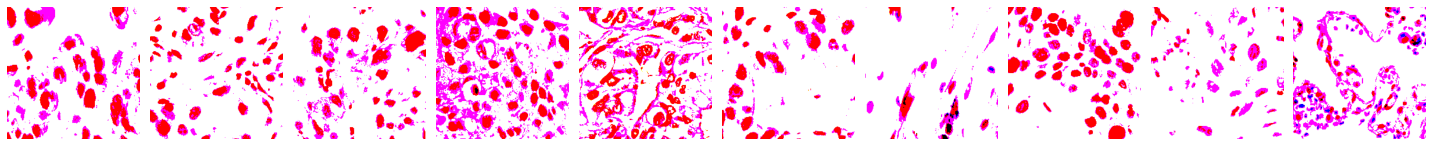

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1.

In [13]:
#plotting the images and checking their corresponding labels
imgs, labels = next(train_batches)
plotImages(imgs)
print(labels)

In [14]:
# Downloading the resnet50 model
input_t = keras.Input(shape=(224,224,3))
res_model = tf.keras.applications.ResNet50(include_top=False,
                                           weights='imagenet',
                                           input_tensor = input_t)

94781440/94765736 [==============================] - 0s 0us/step


In [15]:
#freezing hidden layers from re_train
for i in res_model.layers:
  i.trainable = False

# Fine tuning the downloaded resnet50 model by adding flatten and dense layer
r50_model = keras.models.Sequential()
r50_model.add(res_model)
r50_model.add(keras.layers.Flatten())
r50_model.add(keras.layers.Dense(3,activation='softmax'))

In [ ]:
# loading model DO NOT RUN
r50_model = load_model('/content/resnet50_model.h5')

In [16]:
# Download model summary real resnet50 without modification
res_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [17]:
# Fine tuned resnet50 model summary
r50_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 3)                 301059    
                                                                 
Total params: 23,888,771
Trainable params: 301,059
Non-trainable params: 23,587,712
_________________________________________________________________


In [18]:
#setting hyper-parameters and compiling the model for training
r50_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics='accuracy')

In [ ]:
r50_model.fit(x=train_batches,validation_data=valid_batches, epochs=5,verbose=2)

Epoch 1/5
94/94 - 150s - loss: 0.1942 - accuracy: 0.9260 - val_loss: 0.0989 - val_accuracy: 0.9638 - 150s/epoch - 2s/step
Epoch 2/5


In [ ]:
#saving the trained model 
r50_model.save('resnet50_model.h5')

In [ ]:
#predicting the labels based on the training of the model
prediction = r50_model.predict(x=test_batches, verbose = 0)

In [ ]:
#checking test_batch classes
test_batches.classes

In [ ]:
# function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print('Normalized confusion matrix')
  else:
    print('Confusion matrix, without normalization')
  print(cm)

  thresh = cm.max()/2
  for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,cm[i,j],
             horizontalalignment='center',
             color='white' if cm[i,j] > thresh else 'black')
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [ ]:
#initializing confusion matrix with test batch classes and predicted outputs
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(prediction,axis=-1))
cm_plot_labels = ['aca','n','scc']

Confusion matrix, without normalization
[[196   0   4]
 [  0 200   0]
 [  3   0 197]]


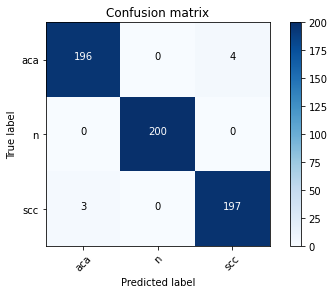

In [ ]:
#Plotting confusion matrix
plot_confusion_matrix(cm=cm, classes=cm_plot_labels)

In [ ]:
#Preprocessing the data to be appropriate for the model processing
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=train_path, target_size=(224,224), classes=['aca','n','scc'],batch_size=128)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['aca','n','scc'],batch_size=128)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=test_path, target_size=(224,224), classes=['aca','n','scc'],batch_size=128,shuffle=False)

#Downloading the model
vgg16_model = tf.keras.applications.vgg16.VGG16()

#Removing last layer from the VGG16 (known as fine tuning)
model = Sequential()
for layer in vgg16_model.layers[:-1]:
  model.add(layer)

#Freezing the hidden layers from trianing
for layer in model.layers:
  layer.trainable = False

# Adding last layers which will give three possible answers corresponding to three classes of the cancer
model.add(Dense(units=3, activation='softmax'))

#setting hyperparameters and compiling the model
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics='accuracy')

#Training the model by providing training and validation set
model.fit(x=train_batches,validation_data=valid_batches, epochs=5,verbose=2)

# Prediction using the trained model and giving the test batches
prediction = model.predict(x=test_batches, verbose=0)

#initializing confusion matrix with test batch classes and predicted outputs
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(prediction,axis=-1))
cm_plot_labels = ['aca','n','scc']

#Plotting confusion matrix
plot_confusion_matrix(cm=cm, classes=cm_plot_labels)